In [21]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.stats
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [22]:
from nn_resampler import nn_resampler
from phase_est_smc import phase_est_smc

In [23]:
num_particles = 1000 # number of SMC particles (num of w points)
num_samples = 100000 # number of samples to draw from the particle distribution (to be binned)
num_bins = 100 # number of bins
n_iters = 100 # number of different omega*
t0 = 0.1 # starting time
max_iters = 200 # maximum number of iterations before breaking
if_print = True

In [24]:
net = nn_resampler(100,100)
net.load_state_dict(torch.load("model/nn_resampler.model"))
net.eval();

## NN Resampler

In [25]:
omega_star_list = []
nn_pred_list = []
nn_data = []

for i in range(n_iters): 
    
    omega_star = np.random.uniform(low=-1, high =1) * np.pi
    
    omega_star_list.append(omega_star)
    smc = phase_est_smc(omega_star, t0, max_iters)
    smc.init_particles(num_particles)
    resample_counts = 0
    
    while True:
        
        particle_pos, particle_wgts = smc.particles(threshold=num_particles/5, num_measurements=1)
        bins, edges = smc.get_bins(num_bins, num_samples)
        
        if smc.break_flag:
            break
            
        nn_pred = net(torch.tensor(bins).float().unsqueeze(0)) ## convert to float tensor, then make dim [1, num_bins]
        smc.nn_bins_to_particles(nn_pred.detach().numpy(), edges)
        
        resample_counts += 1

        
#         if len(running_est) > 5:
#             last_n = running_est[-5:]
#             # np.allclose(a,b) returns true if every element in a and b are equal to a tolerance
#             # np.full_like makes an array with shake of last_n with every element being last_n[0]
#             # if all elements of last_n are equal then they should all equal the first element
#             if np.allclose(last_n, np.full_like(last_n, last_n[0])):
#                 break
    if if_print:            
        print("True omega: {:f}, prediction by NN: {:f}, num of resample calls: {:d}".format(omega_star,
                                                                                             smc.curr_omega_est,
                                                                                             resample_counts))

    while len(smc.data) < max_iters:
        smc.data.append(smc.data[-1]) # append the last estimate
    
    nn_data.append(smc.data)
    nn_pred_list.append(smc.curr_omega_est)
    
    if np.abs(smc.curr_omega_est) - np.abs(omega_star) > 1:
        print("Prediction: {:f}, actual value: {:f}. Threshold exceeded. Breaking out of loop for inspection.".
             format(smc.curr_omega_est, omega_star))

True omega: -1.390903, prediction by NN: -1.104980, num of resample calls: 35
True omega: 2.081618, prediction by NN: 1.784609, num of resample calls: 35
True omega: 0.208088, prediction by NN: -0.200735, num of resample calls: 36
True omega: 2.521297, prediction by NN: -2.536488, num of resample calls: 38
True omega: -2.665238, prediction by NN: -2.616737, num of resample calls: 37
True omega: -2.417880, prediction by NN: -2.456455, num of resample calls: 36
True omega: 1.119522, prediction by NN: -1.019770, num of resample calls: 34
True omega: 0.096498, prediction by NN: 0.096612, num of resample calls: 32
True omega: 2.518130, prediction by NN: 2.232083, num of resample calls: 37
True omega: 0.842379, prediction by NN: 0.800560, num of resample calls: 36
True omega: 0.440656, prediction by NN: 0.447730, num of resample calls: 35
True omega: -1.106544, prediction by NN: -1.077494, num of resample calls: 34
True omega: 3.078680, prediction by NN: -3.109761, num of resample calls: 36


In [26]:
nn_mse = np.mean( np.abs(np.array(omega_star_list)) - np.abs(np.array(nn_pred_list)) ) ** 2
print(nn_mse)

0.0074059440326226834


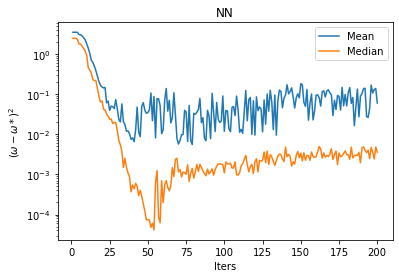

In [27]:
nn_data_squared = ( np.abs(np.array(nn_data)) - np.abs(np.array(omega_star_list)).reshape(-1,1)) ** 2 
nn_data_mean = np.mean(nn_data_squared, axis=0)
nn_data_median = np.median(nn_data_squared, axis =0)

num_data_points = nn_data_squared.shape[1]

plt.plot(np.arange(1,num_data_points+1, dtype=int), nn_data_mean, label='Mean')
plt.plot(np.arange(1,num_data_points+1, dtype=int), nn_data_median, label='Median')
plt.legend()
plt.title("NN")
plt.yscale('log')
plt.xlabel("Iters")
plt.ylabel("$(\omega - \omega*)^2$")
plt.show()

## Liu-West resampler

In [28]:
omega_star_list = []
lw_pred_list = []
lw_data = []

for i in range(n_iters): 
    omega_star = np.random.uniform(low=-1, high=1) * np.pi
    
    omega_star_list.append(omega_star)
    smc = phase_est_smc(omega_star, t0, max_iters)
    smc.init_particles(num_particles)
    
    resample_counts = 0
    
    while True:

        particle_pos, particle_wgts = smc.particles(threshold=num_particles/10, num_measurements=1)
        smc.liu_west_resample()
    
        resample_counts += 1 
        
        curr_omega_est = smc.particle_pos[np.argmax(smc.particle_wgts)]
        if smc.break_flag == True:
            break
        
#         if len(running_est) > 5:
#             last_5 = running_est[-5:]
#             # np.allclose(a,b) returns true if every element in a and b are equal to a tolerance
#             # np.full_like makes an array with shape of last_10 with every element being last_10[0]
#             # if all elements of last_10 are equal then they should all equal the first element
#             if np.allclose(last_5, np.full_like(last_5, last_5[0])):
#                 break
                
      
    if if_print:            
        print("True omega: {:f}, prediction by NN: {:f}, num of resample calls: {:d}".format(omega_star,
                                                                                             smc.curr_omega_est,
                                                                                             resample_counts))

    while len(smc.data) < max_iters:
        smc.data.append(smc.data[-1]) # append the last estimate

    lw_data.append(smc.data)
    lw_pred_list.append(smc.curr_omega_est)
    
    if np.abs(smc.curr_omega_est) - np.abs(omega_star) > 1:
        print("Prediction: {:f}, actual value: {:f}. Threshold exceeded. Breaking out of loop for inspection.".
             format(smc.curr_omega_est, omega_star))

    

True omega: 2.268743, prediction by NN: -0.175144, num of resample calls: 28
True omega: 2.018041, prediction by NN: 2.380683, num of resample calls: 28
True omega: -1.688665, prediction by NN: -1.636166, num of resample calls: 28
True omega: 1.502404, prediction by NN: -0.080678, num of resample calls: 28
True omega: -0.258510, prediction by NN: 0.181723, num of resample calls: 26
True omega: -1.671587, prediction by NN: 0.574049, num of resample calls: 28
True omega: 2.208963, prediction by NN: -3.673349, num of resample calls: 28
Prediction: -3.673349, actual value: 2.208963. Threshold exceeded. Breaking out of loop for inspection.
True omega: 0.891617, prediction by NN: -1.442680, num of resample calls: 27
True omega: 2.724783, prediction by NN: -0.815409, num of resample calls: 28
True omega: -0.064219, prediction by NN: 0.157036, num of resample calls: 25
True omega: -1.973232, prediction by NN: -1.758255, num of resample calls: 27
True omega: -0.602206, prediction by NN: 1.08412

In [29]:
lw_mse = np.mean( np.abs(np.array(omega_star_list)) - np.abs(np.array(lw_pred_list))) ** 2
print(lw_mse)

0.0938460729045162


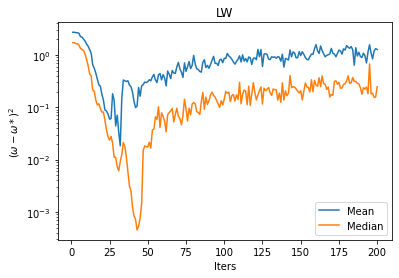

In [30]:
lw_data_squared = ( np.abs(np.array(lw_data)) - np.abs(np.array(omega_star_list)).reshape(-1,1)) ** 2 
lw_data_mean = np.mean(lw_data_squared, axis=0)
lw_data_median = np.median(lw_data_squared, axis =0)

num_data_points = lw_data_squared.shape[1]

plt.plot(np.arange(1,num_data_points+1, dtype=int), lw_data_mean, label='Mean')
plt.plot(np.arange(1,num_data_points+1, dtype=int), lw_data_median, label='Median')
plt.legend()
plt.title("LW")
plt.xlabel("Iters")
plt.ylabel("$(\omega - \omega*)^2$")
plt.yscale('log')
plt.show()